In [6]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# from pandas.core.common import SettingWithCopyWarning
# from pandas_profiling import ProfileReport
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
# import scikitplot as skplt
from yellowbrick.model_selection import FeatureImportances
import scipy.stats as stats
import joblib
import os
%matplotlib inline

In [7]:
# !pip -q install imblearn
# !pip install scikit-plot
!pip -q install yellowbrick


In [8]:
# import data

cc_train_data_original = pd.read_csv(r"E:\1. Projects\credit-card-approval-system\Credit-card-approval\data/train.csv")

In [9]:
cc_train_copy = cc_train_data_original.copy()

##  Transformation of the data

ID:
* Drop the feature

Gender:
* One hot encoding

Age:
* Min-max scaling
* Fix skewness
* Abs value and div 365.25

Marital status:
* One hot encoding

Family member count
* Fix outliers

Children count
* Fix outliers
* Drop feature

Dwelling type
* One hot encoding

Income
* Remove outliers
* Fix skewness
* Min-max scaling

Job title
* One hot encoding
* Impute missing values

Employment status:
* One hot encoding

Education level:
* Ordinal encoding

Employment length:
* Remove outliers
* Min-max scaling
* Abs value and div 365.25
* change days of employments of retirees to 0

Has a car:
* Change it numerical
* One-hot encoding

Has a property:
* Change it numerical
* One-hot encoding

Has a mobile phone:
* Drop feature

Has a work phone:
* One-hot encoding

Has a phone:
* One-hot encoding

Has an email:
* One-hot encoding

Account age:
* Drop feature

Is high risk(Target):
* Change the data type to numerical
* balance the data with SMOTE

In [11]:
#  Outliers cleaning

class OutlierRemoval(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_outliers = ['Family member count', 'Income', 'Employment length']):
        self. feat_with_outliers = feat_with_outliers

    def fit(self, df):
        return self

    def transform(self, df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            Q1 = df[self.feat_with_outliers].quantile(.25)
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3-Q1
            df = df[~((df[self.feat_with_outliers]<(Q1-3*IQR)) | (df[self.feat_with_outliers] > (Q3+3*IQR))).any(axis = 1)]
            return df

        else:
            print("One or more features are not in the dataframe")
            return df

# Feature Selection

In [13]:
## Drop features

class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['ID','Has a mobile phone','Children count','Job title','Account age']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not drop in the dataframe")
            return df

## Feature engineering

In [15]:
# Time conversion

class TimeConversionHandler(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days = ['Employment length', 'Age']):
        self.feat_with_days = feat_with_days

    def fit(self, X, y=None):
        return self

    def transform(self, X, y = None):
        if (set(self.feat_with_days).issubset(X.columns)):
            X[['Employment length', 'Age']] = np.abs(X[['Employment length', 'Age']])
            return X

        else:
            print("One or more features are not in the dataframe")
            return X

In [16]:
# Retiree handling (in the employment length feature)

class RetireeHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        if 'Employment length' in df.columns:
            # select rows with employment length is 365243 which corresponds to retirees
            df_ret_idx = df['Employment length'][df['Employment length'] == 365243].index
            # change 365243 to 0
            df.loc[df_ret_idx,'Employment length'] = 0
            return df
        else:
            print("Employment length is not in the dataframe")
            return df

In [17]:
# Skewness handling
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_skewness=['Income','Age']):
        self.feat_with_skewness = feat_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.feat_with_skewness] = np.cbrt(df[self.feat_with_skewness])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df


In [18]:
# Binning

class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['Has a work phone','Has a phone','Has an email']):
        self.feat_with_num_enc = feat_with_num_enc
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            # Change 0 to N and 1 to Y for all the features in feat_with_num_enc
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({1:'Y',0:'N'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [19]:
# one-hot encoding

class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Marital status', 'Dwelling', 'Employment status', 'Has a car', 'Has a property', 'Has a work phone', 'Has a phone', 'Has an email']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            # function to one hot encode the features in one_hot_enc_ft
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get the result of the one hot encoding columns names
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the array of the one hot encoding to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # function to concatenat the one hot encoded features with the rest of features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # one hot encoded dataframe
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

In [20]:
# ordinal encoding
class OrdinalFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_enc_ft = ['Education level']):
        self.ordinal_enc_ft = ordinal_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Education level' in df.columns:
            ordinal_enc = OrdinalEncoder()
            df[self.ordinal_enc_ft] = ordinal_enc.fit_transform(df[self.ordinal_enc_ft])
            return df
        else:
            print("Education level is not in the dataframe")
            return df




In [21]:
# Min max scaling

class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income', 'Employment length']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [22]:
# change types of the target fetaure

class ChangeToNumTarget(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            df['Is high risk'] = pd.to_numeric(df['Is high risk'])
            return df
        else:
            print("Is high risk is not in the dataframe")
            return df

In [23]:
# Oversampling

class Oversample(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            # smote function to oversample the minority class to fix the imbalance data
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'Is high risk'],df['Is high risk'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("Is high risk is not in the dataframe")
            return df

## Data preprocessing

In [25]:
def full_pipeline(df):
    # Create the pipeline that will call all the class from OutlierRemoval to OversampleSMOTE in one go
    pipeline = Pipeline([
        ('outlier_remover', OutlierRemoval()),
        ('feature_dropper', DropFeatures()),
        ('time_conversion_handler', TimeConversionHandler()),
        ('retiree_handler', RetireeHandler()),
        ('skewness_handler', SkewnessHandler()),
        ('binning_num_to_yn', BinningNumToYN()),
        ('one_hot_with_feat_names', OneHotWithFeatNames()),
        ('ordinal_feat_names', OrdinalFeatNames()),
        
        ('min_max_with_feat_names', MinMaxWithFeatNames()),
        ('change_to_num_target', ChangeToNumTarget()),
        # ('oversample', Oversample())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [26]:
pd.options.mode.chained_assignment = None  # Hide the copy warning
cc_train_prep = full_pipeline(cc_train_copy)

One or more features are not drop in the dataframe


In [27]:
cc_train_prep.shape

(23673, 38)

In [28]:
pd.set_option('display.max_columns', None)
cc_train_prep.head()

,Gender_F,Gender_M,Marital status_Civil marriage,Marital status_Married,Marital status_Separated,Marital status_Single / not married,Marital status_Widow,Dwelling_Co-op apartment,Dwelling_House / apartment,Dwelling_Municipal apartment,Dwelling_Office apartment,Dwelling_Rented apartment,Dwelling_With parents,Employment status_Commercial associate,Employment status_Pensioner,Employment status_State servant,Employment status_Student,Employment status_Working,Has a car_N,Has a car_Y,Has a property_N,Has a property_Y,Has a work phone_N,Has a work phone_Y,Has a phone_N,Has a phone_Y,Has an email_N,Has an email_Y,ID,Children count,Income,Education level,Age,Employment length,Has a mobile phone,Job title,Family member count,Is high risk
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,5037048,0,0.417817,4.0,0.602718,0.273442,1,Core staff,2.0,0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,5044630,1,0.417817,1.0,0.203417,0.144410,1,Accountants,2.0,0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,5079079,2,0.519094,4.0,0.394044,0.498453,1,Laborers,4.0,0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,5112872,0,0.806979,1.0,0.841939,0.179319,1,Managers,1.0,0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,5105858,0,0.679378,4.0,0.599130,0.044012,1,NaN,1.0,0


In [29]:
cc_train_prep = cc_train_prep.drop(columns = ['ID', 'Job title', 'Has a mobile phone', 'Children count',])

In [30]:
cc_train_prep.head()

,Gender_F,Gender_M,Marital status_Civil marriage,Marital status_Married,Marital status_Separated,Marital status_Single / not married,Marital status_Widow,Dwelling_Co-op apartment,Dwelling_House / apartment,Dwelling_Municipal apartment,Dwelling_Office apartment,Dwelling_Rented apartment,Dwelling_With parents,Employment status_Commercial associate,Employment status_Pensioner,Employment status_State servant,Employment status_Student,Employment status_Working,Has a car_N,Has a car_Y,Has a property_N,Has a property_Y,Has a work phone_N,Has a work phone_Y,Has a phone_N,Has a phone_Y,Has an email_N,Has an email_Y,Income,Education level,Age,Employment length,Family member count,Is high risk
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.417817,4.0,0.602718,0.273442,2.0,0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.417817,1.0,0.203417,0.144410,2.0,0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.519094,4.0,0.394044,0.498453,4.0,0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.806979,1.0,0.841939,0.179319,1.0,0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.679378,4.0,0.599130,0.044012,1.0,0


# Short-list promising models

In [32]:
# Models 

classifiers = {
    'sgd':SGDClassifier(random_state=42,loss='perceptron'),
    'logistic_regression':LogisticRegression(random_state=42,max_iter=1000),
    'support_vector_machine':SVC(random_state=42,probability=True),
    'decision_tree':DecisionTreeClassifier(random_state=42),
    'random_forest':RandomForestClassifier(random_state=42),
    'gaussian_naive_bayes':GaussianNB(),
    'k_nearest_neighbors':KNeighborsClassifier(),
    'gradient_boosting':GradientBoostingClassifier(random_state=42),
    'linear_discriminant_analysis':LinearDiscriminantAnalysis(),
    'bagging':BaggingClassifier(random_state=42),
    'neural_network':MLPClassifier(random_state=42,max_iter=1000),
    'adaboost':AdaBoostClassifier(random_state=42),
    'extra_trees':ExtraTreesClassifier(random_state=42),
    }

In [33]:
def feat_importance_plot(model_trn, model_name):
    if model_name not in ['sgd','support_vector_machine','gaussian_naive_bayes','k_nearest_neighbors','bagging','neural_network']:
        # change xtick font size
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        # top 10 most predictive features
        top_10_feat = FeatureImportances(model_trn, relative=False, topn=10)
        # top 10 least predictive features
        bottom_10_feat = FeatureImportances(model_trn, relative=False, topn=-10)
        #change the figure size
        plt.figure(figsize=(10, 4))
        #change x label font size
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        top_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        # show the plot
        top_10_feat.show()
        print('\n')
        plt.figure(figsize=(10, 4))
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        bottom_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        # show the plot
        bottom_10_feat.show()
        print('\n')
    else:
        print('No feature importance for {0}'.format(model_name))
        print('\n')

In [34]:
# Function to get the y prediction
def y_prediction_func(model_trn,model_name,final_model=False):
    if final_model == False:
        # check if y_train_copy_pred exists, if not create it
        y_cc_train_pred_path = Path('saved_models/{0}/y_train_copy_pred_{0}.sav'.format(model_name))
        try:
            y_cc_train_pred_path.resolve(strict=True)
        except FileNotFoundError:
            #cross validation prediction with kfold = 10
            y_cc_train_pred = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
            #save the predictions
            joblib.dump(y_cc_train_pred,y_cc_train_pred_path)
            return y_cc_train_pred
        else:
            # if it exist load the predictions
            y_cc_train_pred = joblib.load(y_cc_train_pred_path)
            return y_cc_train_pred
    else:
        # check if y_train_copy_pred exists, if not create it
        y_cc_train_pred_path_final = Path('saved_models_final/{0}/y_train_copy_pred_{0}_final.sav'.format(model_name))
        try:
            y_cc_train_pred_path_final.resolve(strict=True)
        except FileNotFoundError:
            #cross validation prediction with kfold = 10
            y_cc_train_pred_final = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
            #save the predictions
            joblib.dump(y_cc_train_pred_final,y_cc_train_pred_path_final)
            return y_cc_train_pred_final
        else:
            # if it exist load the predictions
            y_cc_train_pred_final = joblib.load(y_cc_train_pred_path_final)
            return y_cc_train_pred_final

In [35]:
# Function to plot the confusion matrix
def confusion_matrix_func(model_trn,model_name,final_model=False):
    if final_model == False:
        fig, ax = plt.subplots(figsize=(8,8))
        #plot confusion matrix
        conf_matrix = ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,y_prediction_func(model_trn,model_name),ax=ax, cmap='Blues',values_format='d')
        # remove the grid
        plt.grid(visible=None)
        # increase the font size of the x and y labels
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        #give a title to the plot using the model name
        plt.title('Confusion Matrix', fontsize=14)
        #show the plot
        plt.show()
        print('\n')
    else:
        fig, ax = plt.subplots(figsize=(8,8))
        #plot confusion matrix
        conf_matrix_final = ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,y_prediction_func(model_trn,model_name,final_model=True),ax=ax, cmap='Blues',values_format='d')
        # remove the grid
        plt.grid(visible=None)
        # increase the font size of the x and y labels
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        #give a title to the plot using the model name
        plt.title('Confusion Matrix', fontsize=14)
        #show the plot
        plt.show()
        print('\n')

In [36]:
# Function to plot the roc curve
def roc_curve_func(model_trn,model_name,final_model=False):
    if final_model == False:
        # check if y probabilities file exists, if not create it
        y_proba_path = Path('saved_models/{0}/y_cc_train_proba_{0}.sav'.format(model_name))
        try:
            y_proba_path.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_proba = model_trn.predict_proba(X_cc_train_prep)
            joblib.dump(y_cc_train_proba,y_proba_path)
        else:
            # if path exist load the y probabilities file
            y_cc_train_proba = joblib.load(y_proba_path)
        # skplt.metrics.plot_roc(y_cc_train_prep, y_cc_train_proba, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
        #remove the grid
        plt.grid(visible=None)
        plt.show()
        print('\n')
    else:
        # check if y probabilities file exists, if not create it
        y_proba_path_final = Path('saved_models_final/{0}/y_cc_train_proba_{0}_final.sav'.format(model_name))
        try:
            y_proba_path_final.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_proba_final = model_trn.predict_proba(X_cc_train_prep)
            joblib.dump(y_cc_train_proba_final,y_proba_path_final)
        else:
            # if path exist load the y probabilities file
            y_cc_train_proba_final = joblib.load(y_proba_path_final)
        skplt.metrics.plot_roc(y_cc_train_prep, y_cc_train_proba_final, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
        #remove the grid
        plt.grid(visible=None)
        plt.show()
        print('\n')

In [37]:
# Function to display the classification report
def score_func(model_trn, model_name, final_model=False):
    if final_model == False:
        class_report = classification_report(y_cc_train_prep,y_prediction_func(model_trn,model_name))
        print(class_report)
    else:
        class_report_final = classification_report(y_cc_train_prep,y_prediction_func(model_trn,model_name,final_model=True))
        print(class_report_final)

In [38]:
# Function to train the model
def train_model(model,model_name,final_model=False):
    # if we are not training the final model
    if final_model == False:
        # check if the model file exist and if not create, train and save it
        model_file_path = Path('saved_models/{0}/{0}_model.sav'.format(model_name))
        try:
            model_file_path.resolve(strict=True)
        except FileNotFoundError:
            if model_name == 'sgd':
                # for sgd, loss = 'hinge' does not have a predict_proba method. Therefore, we use a calibrated model
                calibrated_model = CalibratedClassifierCV(model, cv=10, method='sigmoid')
                model_trn = calibrated_model.fit(X_cc_train_prep,y_cc_train_prep)
            else:
                model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
            joblib.dump(model_trn,model_file_path)
            # plot the most and least predictive features
            return model_trn
        else:
            # if path exist load the model
            model_trn = joblib.load(model_file_path)
            # plot the most and least predictive features
            return model_trn
    else:
        # check if the final model file exist and if not create, train and save it
        final_model_file_path = Path('saved_models_final/{0}/{0}_model.sav'.format(model_name))
        try:
            final_model_file_path.resolve(strict=True)
        except FileNotFoundError:
            model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
            joblib.dump(model_trn,final_model_file_path)
            # plot the most and least predictive features
            return model_trn
        else:
            # if path exist load the model
            model_trn = joblib.load(final_model_file_path)
            # plot the most and least predictive features
            return model_trn

In [39]:
def folder_check_model():
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_models/{}'.format(model_name)):
        os.makedirs('saved_models/{}'.format(model_name))

In [40]:
# split the train data into X and y (target)
X_cc_train_prep, y_cc_train_prep = cc_train_prep.loc[:, cc_train_prep.columns != 'Is high risk'], cc_train_prep['Is high risk'].astype('int64')





----------------------  sgd  ----------------------


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     23272
           1       0.00      0.00      0.00       401

    accuracy                           0.98     23673
   macro avg       0.49      0.50      0.50     23673
weighted avg       0.97      0.98      0.97     23673



C:\Users\Public\Anaconda\anaconda3\envs\credit-approval\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Public\Anaconda\anaconda3\envs\credit-approval\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Public\Anaconda\anaconda3\envs\credit-approval\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

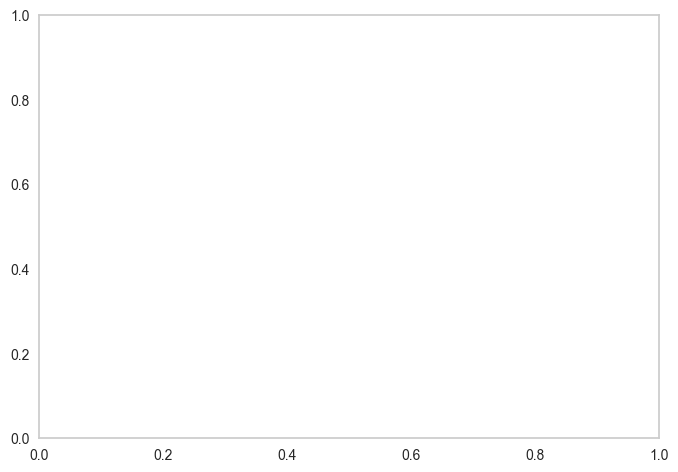

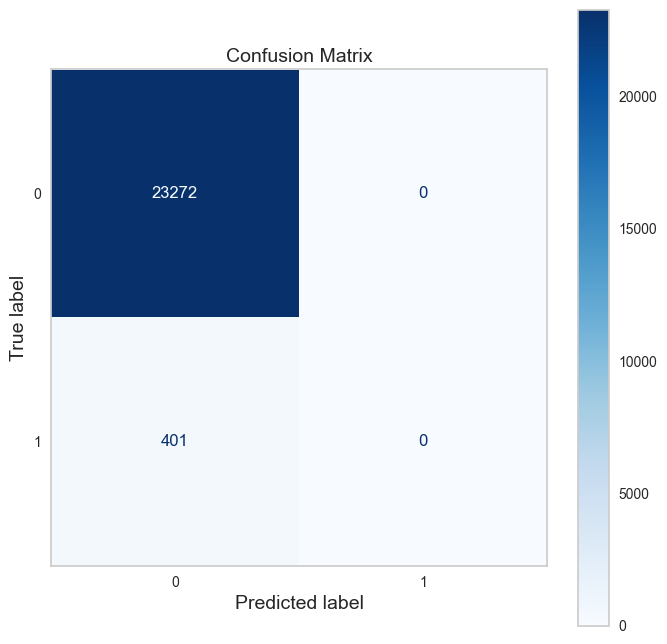



No feature importance for sgd






----------------------  logistic_regression  ----------------------


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     23272
           1       1.00      0.03      0.06       401

    accuracy                           0.98     23673
   macro avg       0.99      0.51      0.52     23673
weighted avg       0.98      0.98      0.98     23673



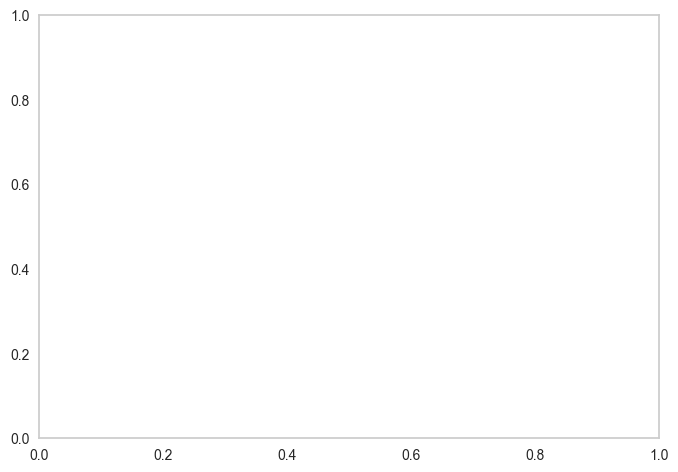

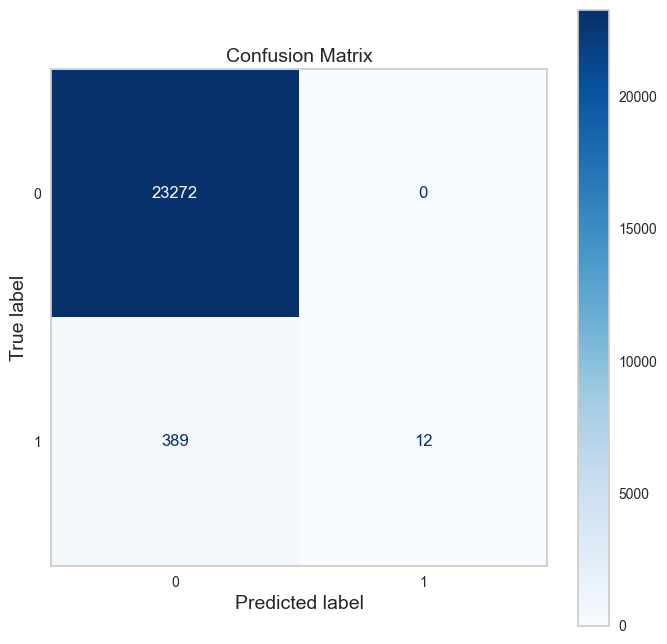

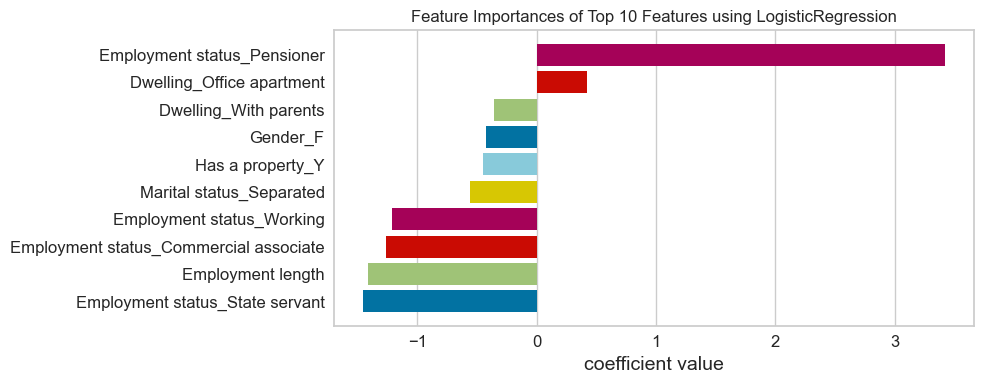

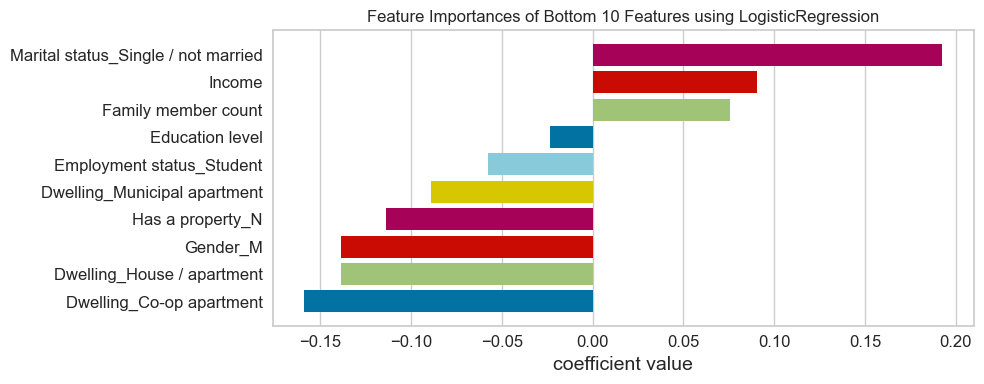







----------------------  support_vector_machine  ----------------------


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     23272
           1       0.00      0.00      0.00       401

    accuracy                           0.98     23673
   macro avg       0.49      0.50      0.50     23673
weighted avg       0.97      0.98      0.97     23673



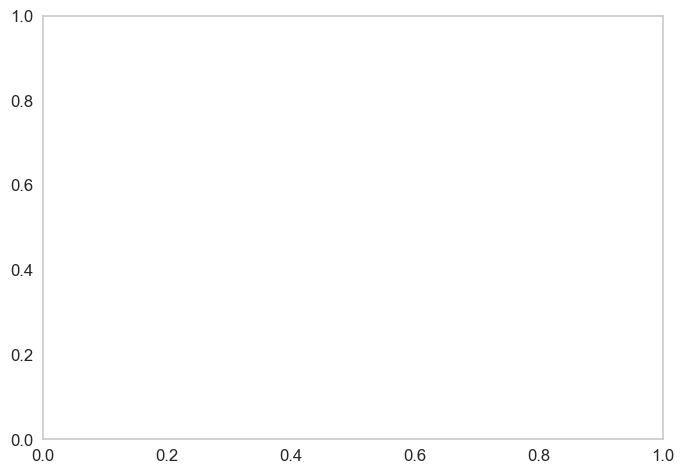

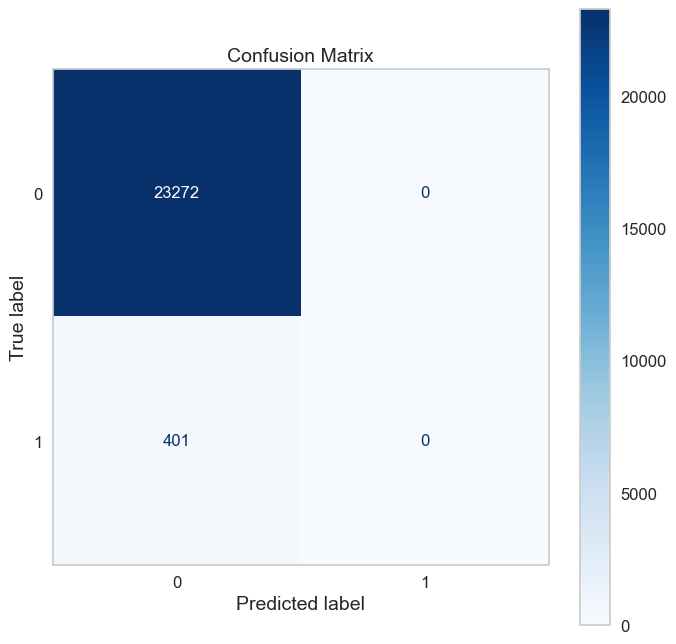



No feature importance for support_vector_machine






----------------------  decision_tree  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23272
           1       0.32      0.17      0.22       401

    accuracy                           0.98     23673
   macro avg       0.65      0.58      0.61     23673
weighted avg       0.97      0.98      0.98     23673



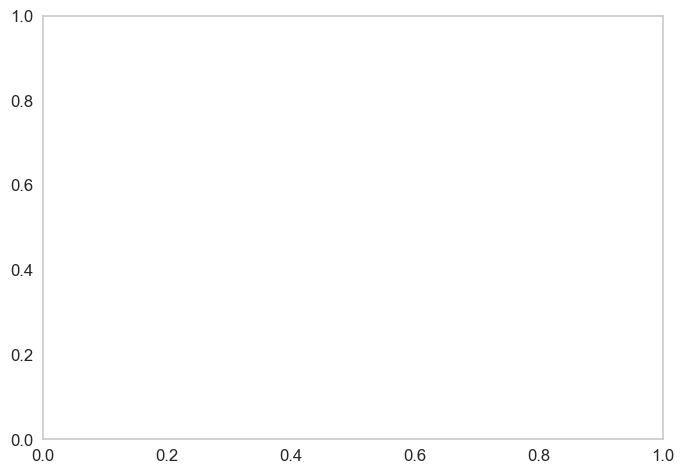

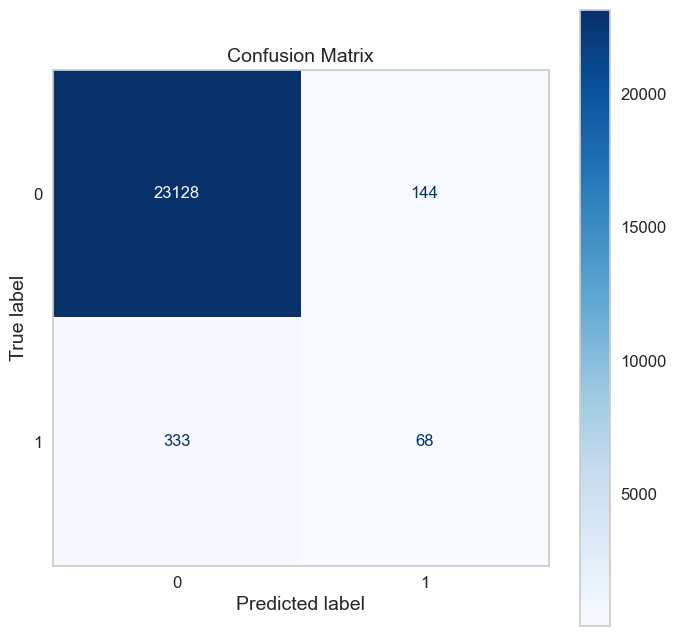

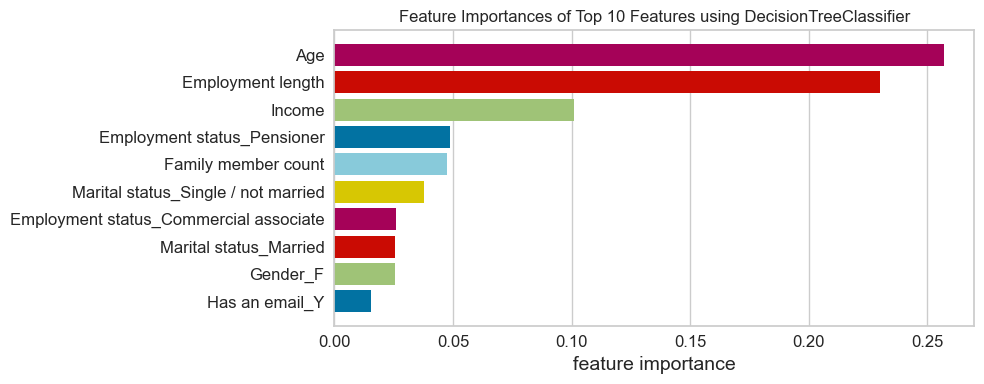

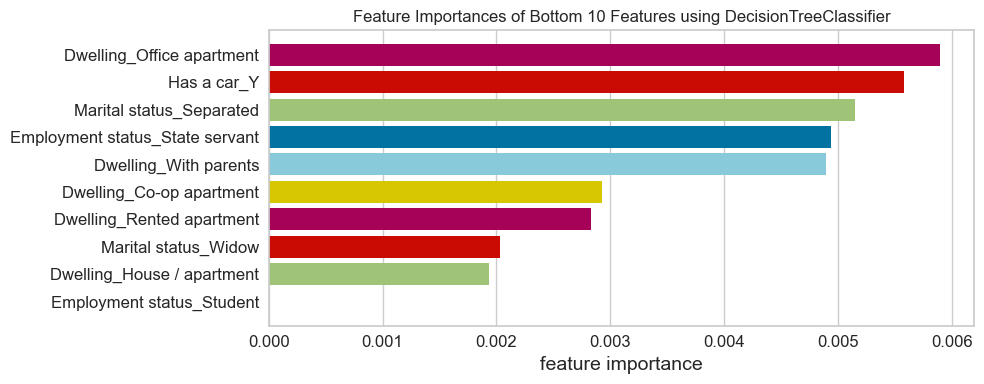







----------------------  random_forest  ----------------------


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     23272
           1       0.39      0.15      0.22       401

    accuracy                           0.98     23673
   macro avg       0.69      0.57      0.60     23673
weighted avg       0.98      0.98      0.98     23673



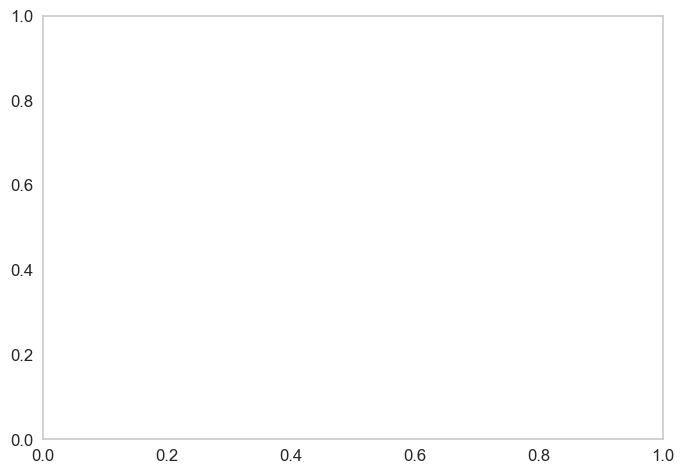

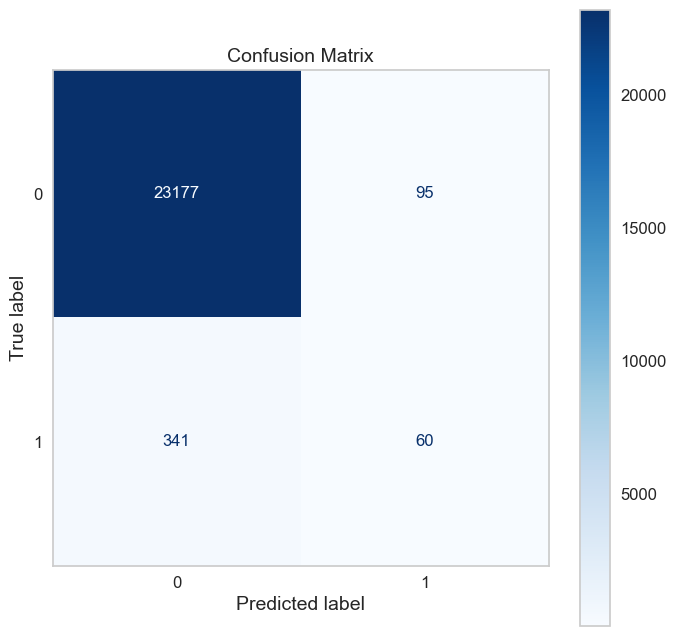

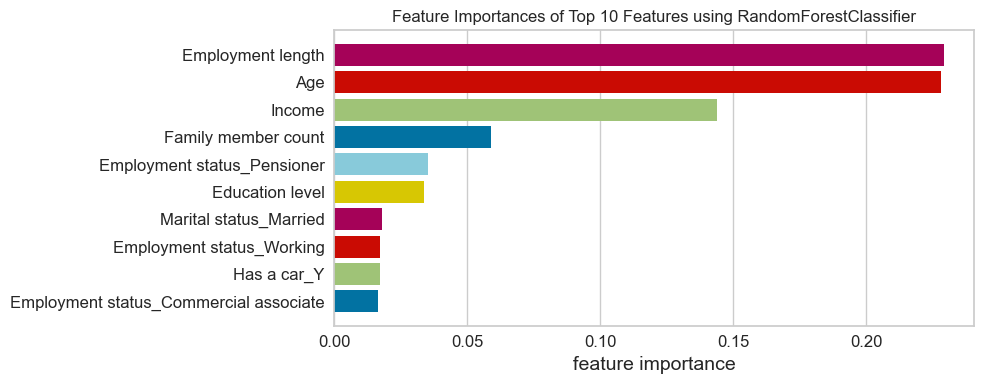

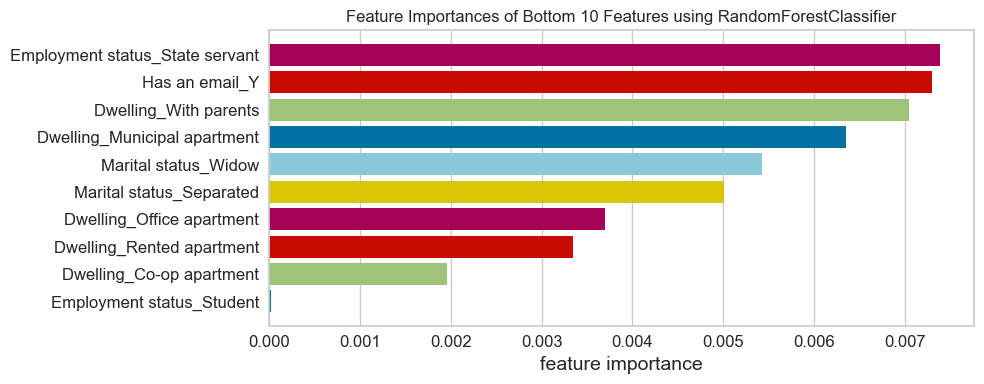







----------------------  gaussian_naive_bayes  ----------------------


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     23272
           1       0.04      0.05      0.04       401

    accuracy                           0.96     23673
   macro avg       0.51      0.52      0.51     23673
weighted avg       0.97      0.96      0.96     23673



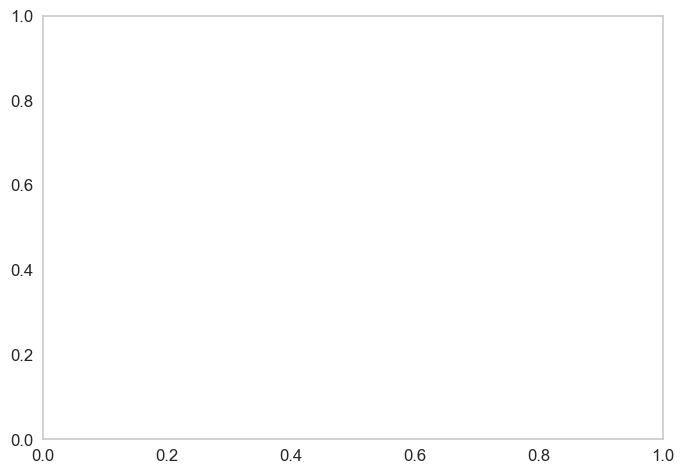

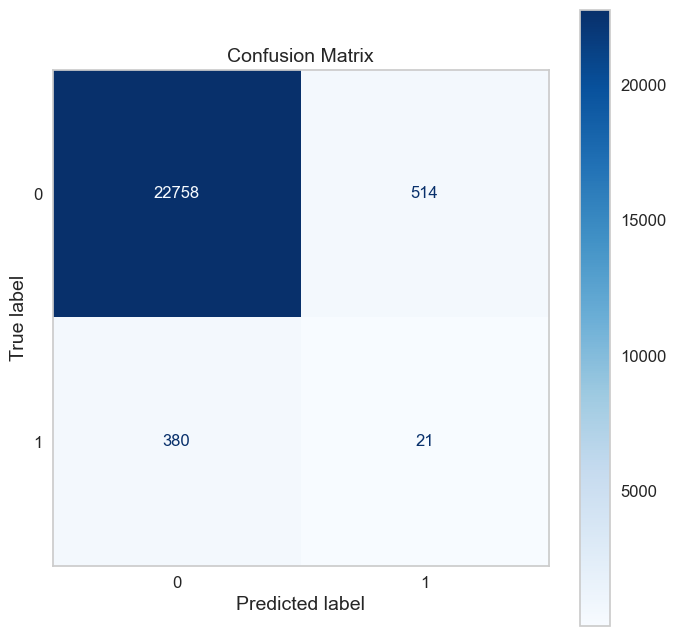



No feature importance for gaussian_naive_bayes






----------------------  k_nearest_neighbors  ----------------------


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     23272
           1       0.12      0.02      0.03       401

    accuracy                           0.98     23673
   macro avg       0.55      0.51      0.51     23673
weighted avg       0.97      0.98      0.97     23673



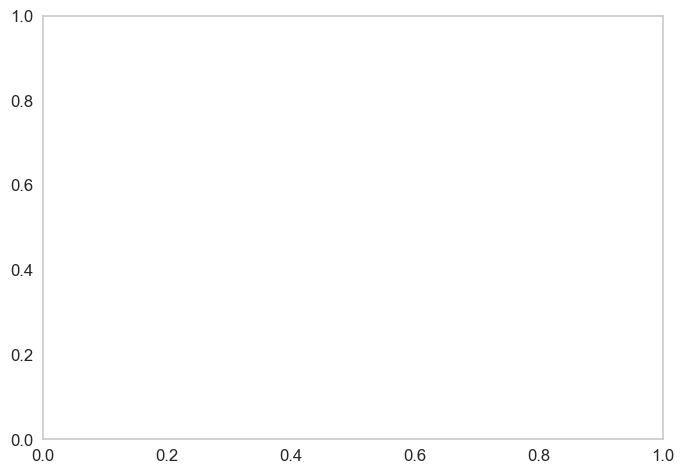

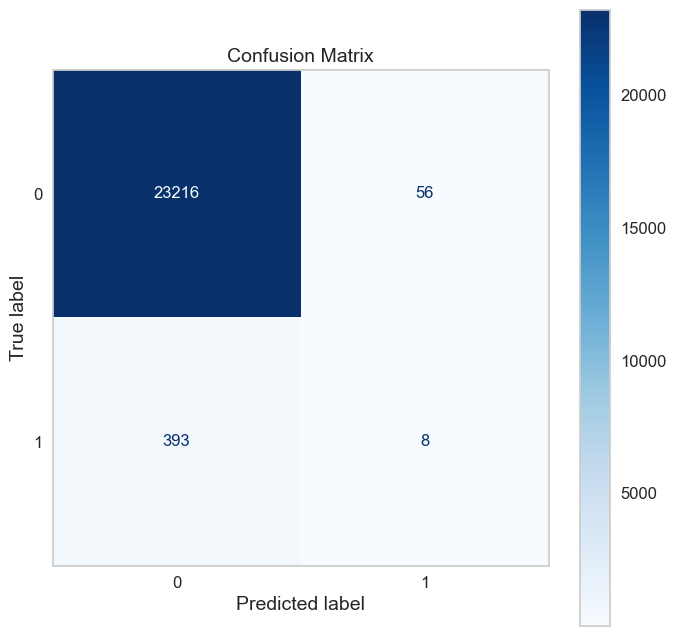



No feature importance for k_nearest_neighbors






----------------------  gradient_boosting  ----------------------


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     23272
           1       0.49      0.05      0.09       401

    accuracy                           0.98     23673
   macro avg       0.74      0.52      0.54     23673
weighted avg       0.98      0.98      0.98     23673



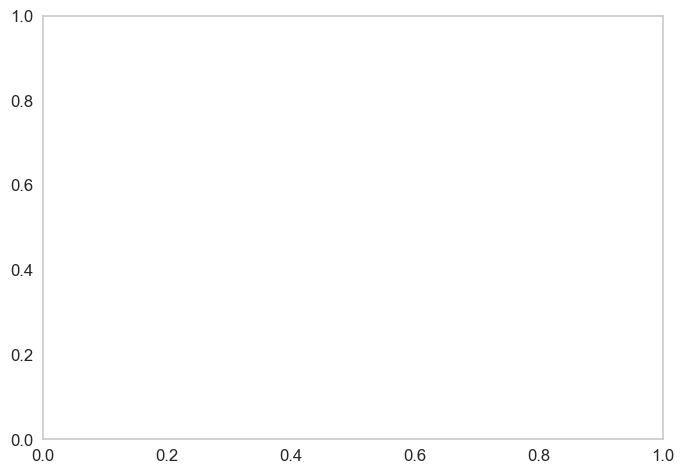

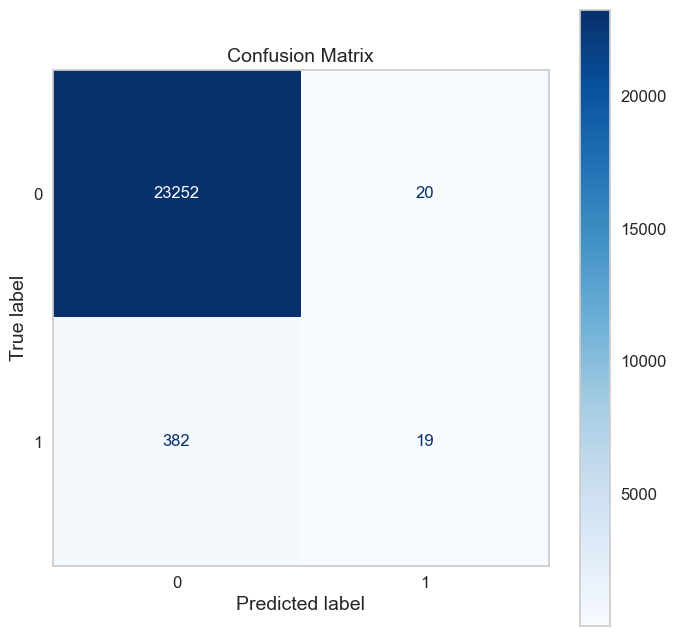

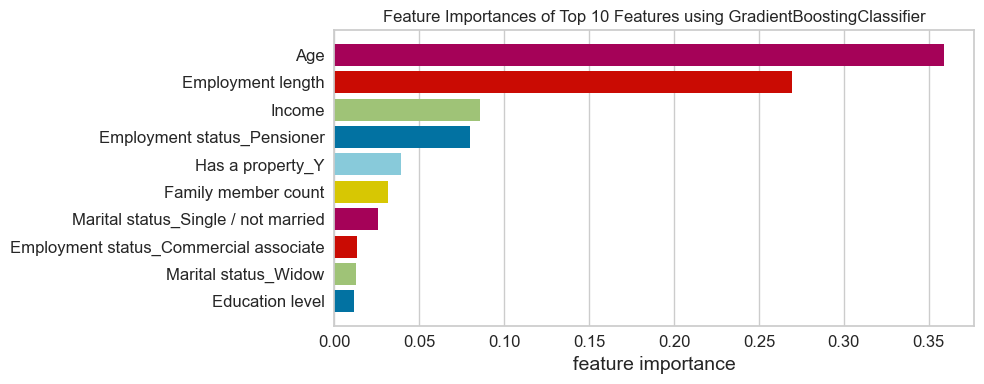

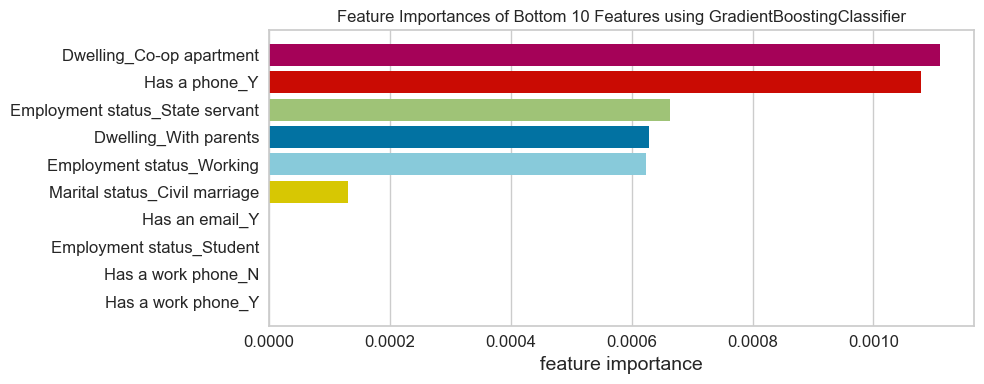







----------------------  linear_discriminant_analysis  ----------------------


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     23272
           1       1.00      0.03      0.06       401

    accuracy                           0.98     23673
   macro avg       0.99      0.51      0.52     23673
weighted avg       0.98      0.98      0.98     23673



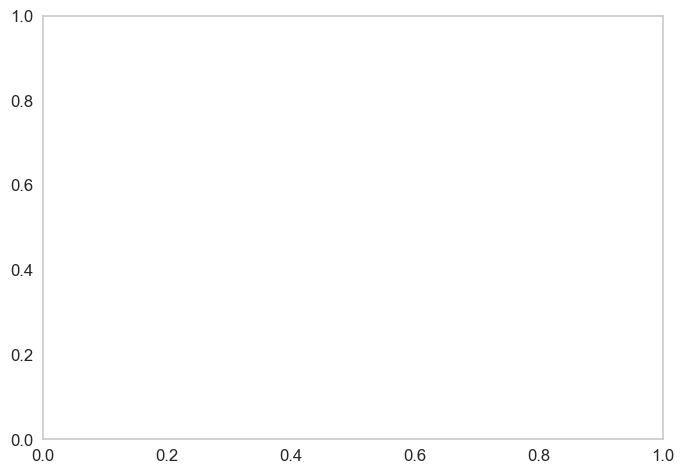

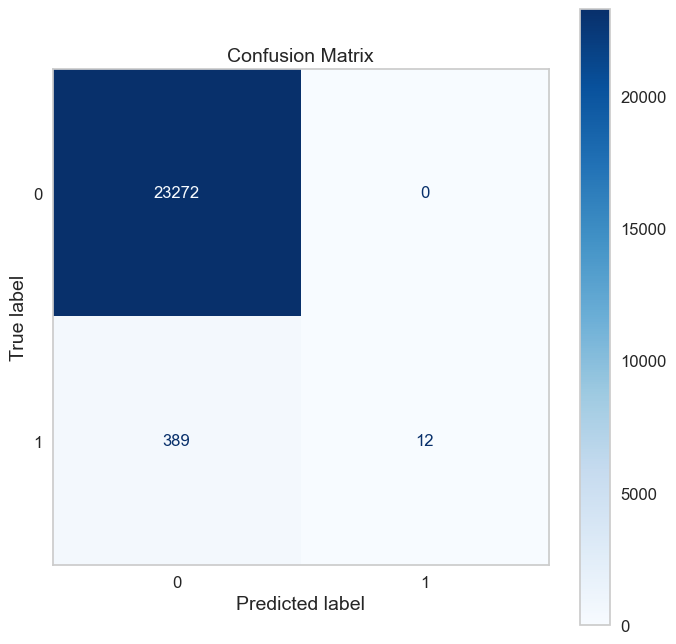

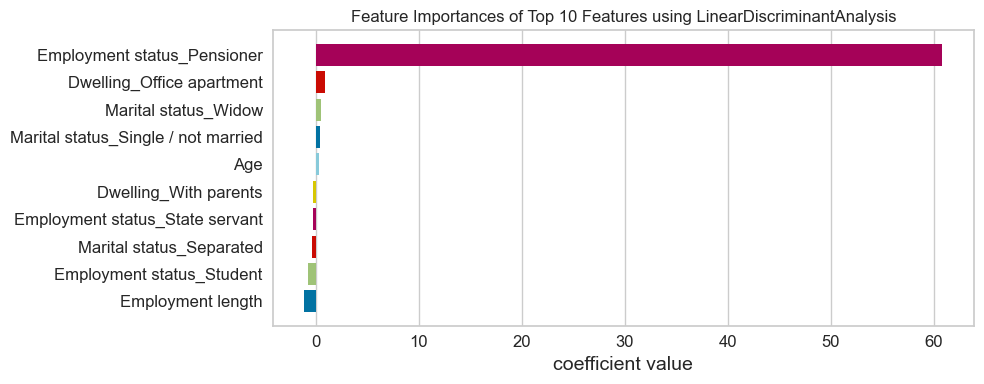

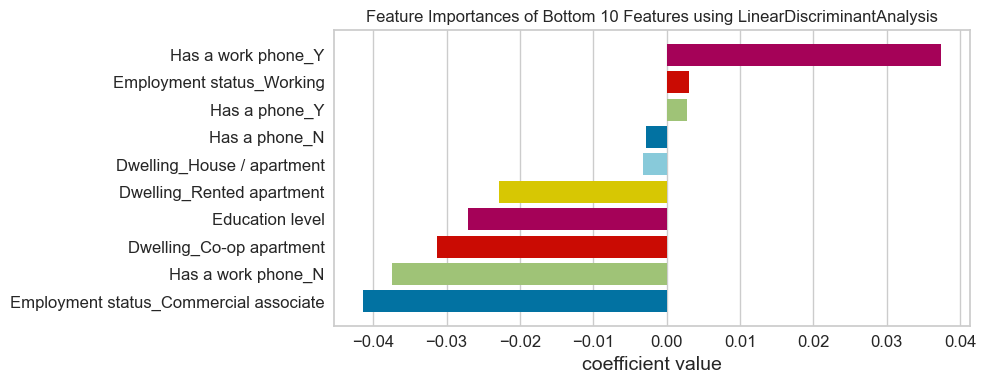







----------------------  bagging  ----------------------


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     23272
           1       0.41      0.19      0.26       401

    accuracy                           0.98     23673
   macro avg       0.70      0.59      0.63     23673
weighted avg       0.98      0.98      0.98     23673



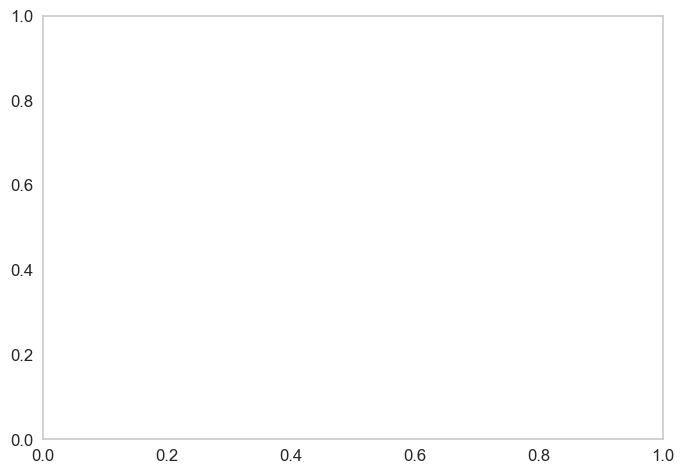

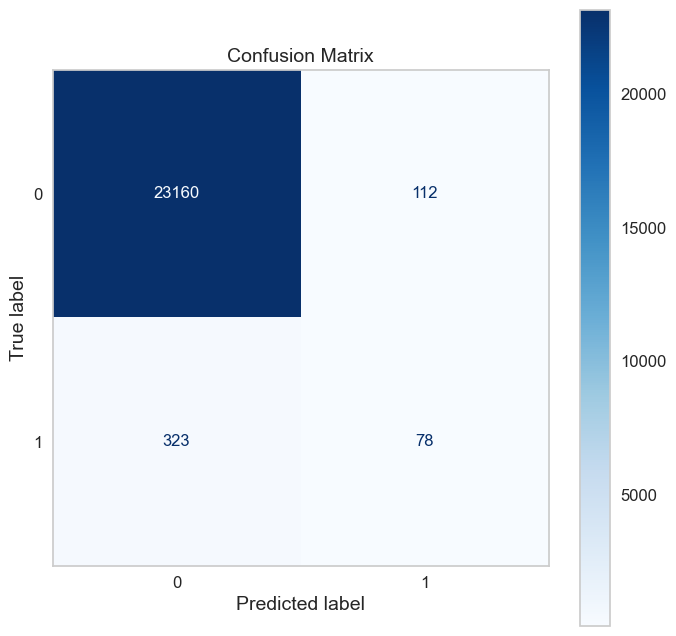



No feature importance for bagging






----------------------  neural_network  ----------------------


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     23272
           1       0.49      0.04      0.08       401

    accuracy                           0.98     23673
   macro avg       0.73      0.52      0.53     23673
weighted avg       0.98      0.98      0.98     23673



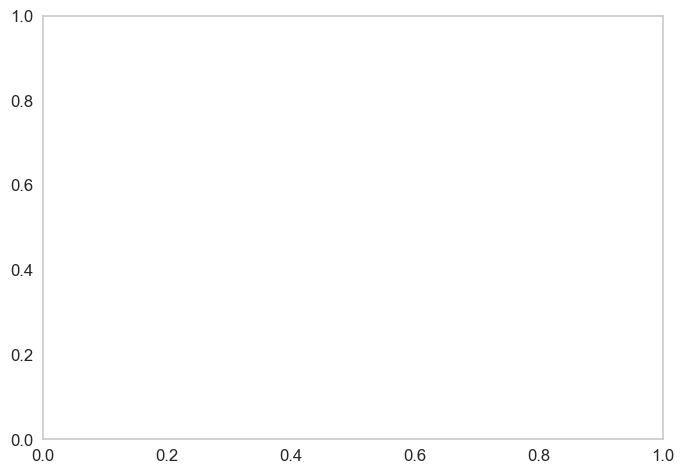

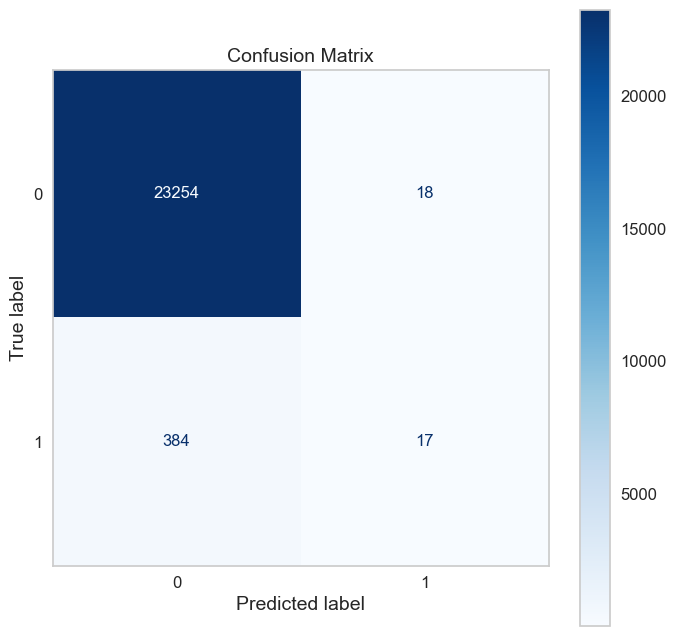



No feature importance for neural_network






----------------------  adaboost  ----------------------


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     23272
           1       1.00      0.03      0.06       401

    accuracy                           0.98     23673
   macro avg       0.99      0.51      0.52     23673
weighted avg       0.98      0.98      0.98     23673



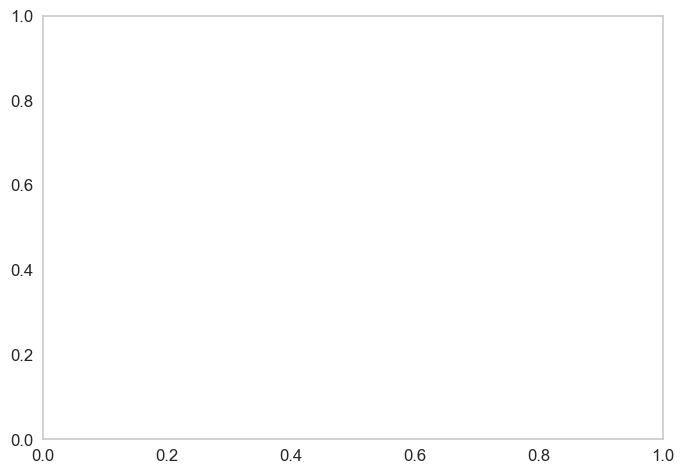

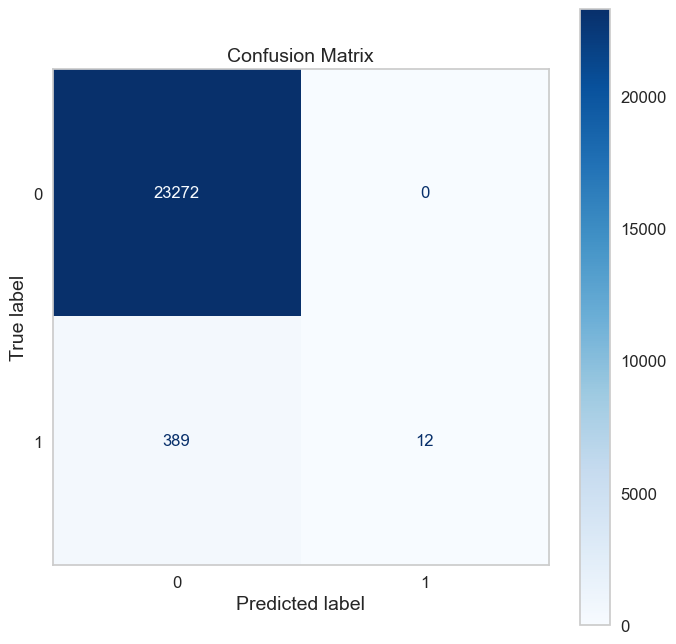

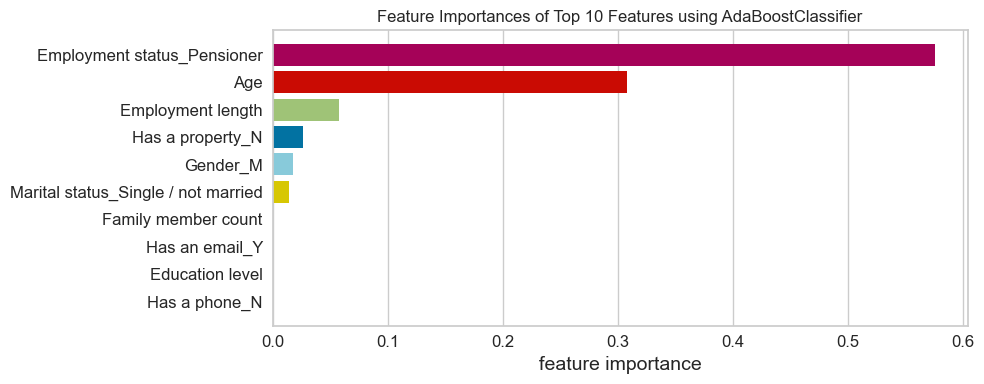

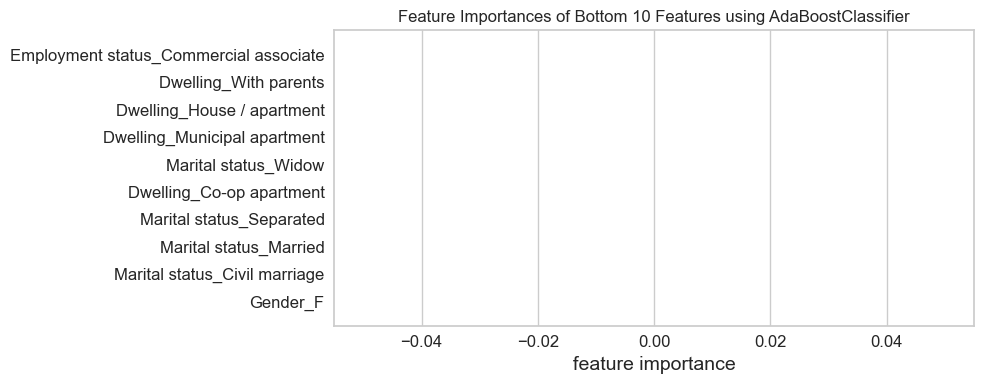







----------------------  extra_trees  ----------------------


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     23272
           1       0.38      0.13      0.20       401

    accuracy                           0.98     23673
   macro avg       0.68      0.57      0.59     23673
weighted avg       0.98      0.98      0.98     23673



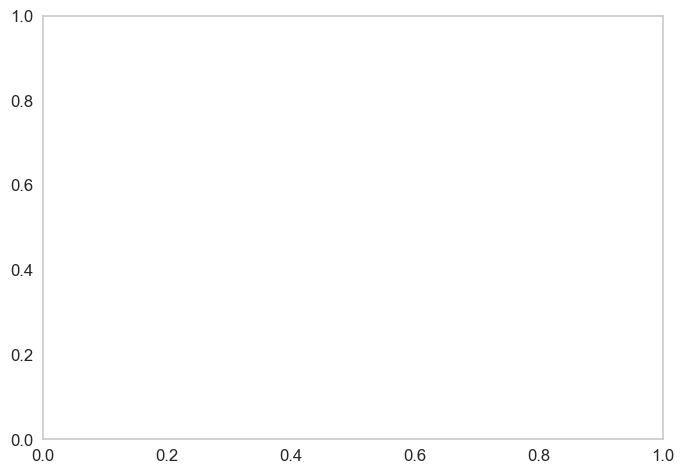

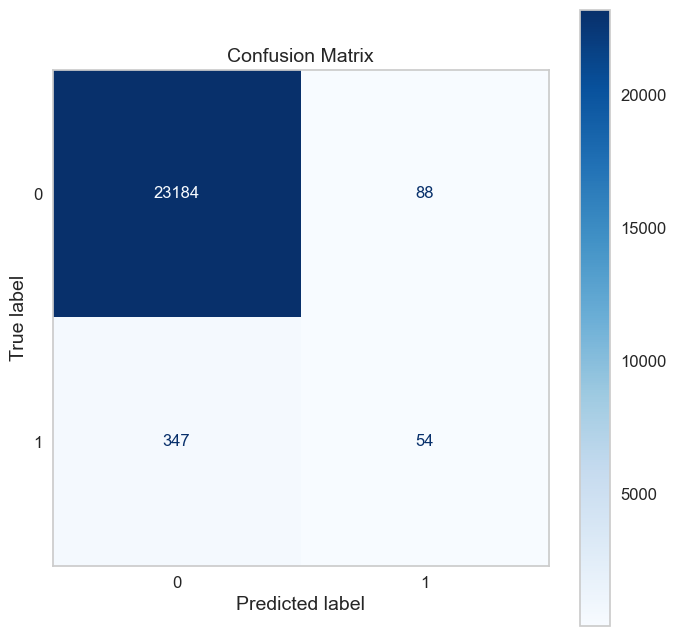

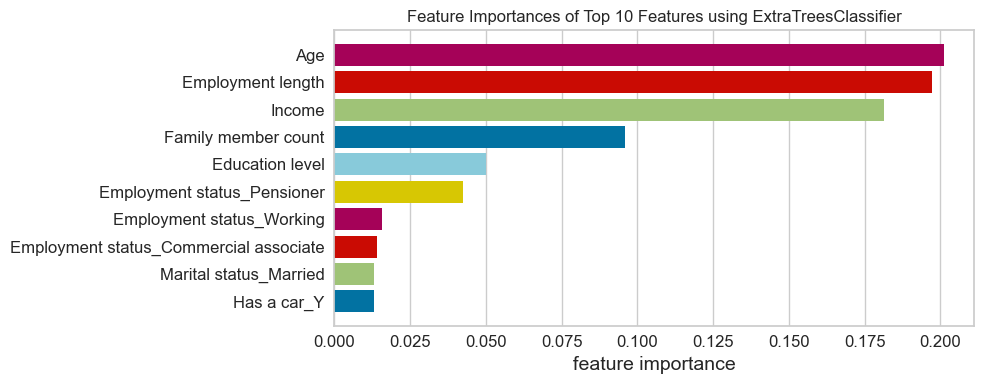

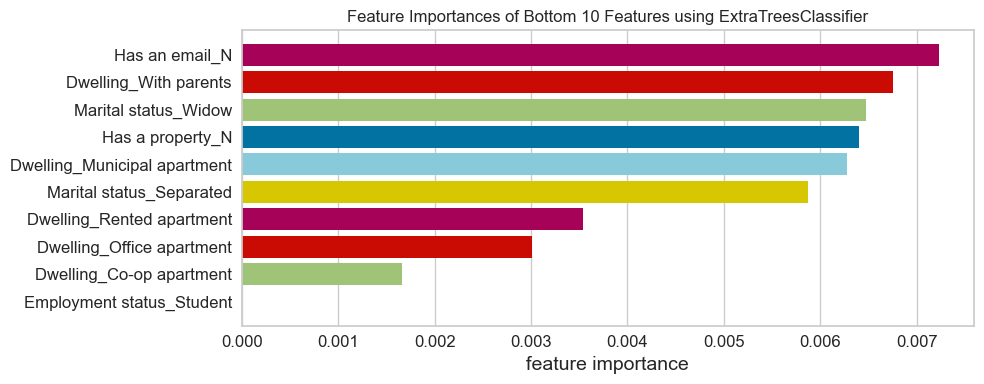

In [41]:
# loop over all the models
for model_name,model in classifiers.items():
    # title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    # check if the folder for saving the model exists, if not create it
    folder_check_model()
    # train the model
    model_trn = train_model(model,model_name)
    # print the scores from the classification report
    score_func(model_trn, model_name)
    # plot the ROC curve
    roc_curve_func(model_trn,model_name)
    # plot the confusion matrix
    confusion_matrix_func(model_trn,model_name)
    # plot feature importance
    feat_importance_plot(model_trn, model_name)
    warnings.filterwarnings("ignore")


# What metrics to use for this problem ?


In [43]:
cc_test_original = pd.read_csv(r"E:\1. Projects\credit-card-approval-system\Credit-card-approval\data\test.csv")

In [77]:
cc_test_copy = cc_test_original.copy()

In [81]:
cc_test_copy.head()

,ID,Gender,Has a car,Has a property,Children count,Income,Employment status,Education level,Marital status,Dwelling,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Job title,Family member count,Is high risk
0,5091261,F,N,Y,0,202500.0,State servant,Secondary / secondary special,Separated,House / apartment,-16834,-1692,1,0,0,0,Medicine staff,1.0,0
1,5096963,M,Y,N,0,675000.0,Commercial associate,Higher education,Married,House / apartment,-18126,-948,1,0,1,0,Managers,2.0,0
2,5087880,F,N,N,0,234000.0,State servant,Higher education,Civil marriage,House / apartment,-21967,-5215,1,0,0,1,Core staff,2.0,0
3,5021949,F,Y,Y,0,445500.0,Commercial associate,Higher education,Married,House / apartment,-12477,-456,1,0,0,0,Managers,2.0,0
4,5105705,F,Y,N,0,225000.0,Working,Secondary / secondary special,Married,Municipal apartment,-12155,-667,1,0,0,0,Laborers,2.0,0


In [83]:
cc_test_prep = full_pipeline(cc_test_copy)

One or more features are not drop in the dataframe


In [85]:
cc_test_prep.head()

,Gender_F,Gender_M,Marital status_Civil marriage,Marital status_Married,Marital status_Separated,Marital status_Single / not married,Marital status_Widow,Dwelling_Co-op apartment,Dwelling_House / apartment,Dwelling_Municipal apartment,Dwelling_Office apartment,Dwelling_Rented apartment,Dwelling_With parents,Employment status_Commercial associate,Employment status_Pensioner,Employment status_State servant,Employment status_Student,Employment status_Working,Has a car_N,Has a car_Y,Has a property_N,Has a property_Y,Has a work phone_N,Has a work phone_Y,Has a phone_N,Has a phone_Y,Has an email_N,Has an email_Y,ID,Children count,Income,Education level,Age,Employment length,Has a mobile phone,Job title,Family member count,Is high risk
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,5091261,0,0.558460,4.0,0.636786,0.150359,1,Medicine staff,1.0,0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,5087880,0,0.614833,1.0,0.886448,0.466607,1,Core staff,2.0,0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,5021949,0,0.901660,1.0,0.381072,0.039408,1,Managers,2.0,0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,5105705,0,0.599271,4.0,0.359938,0.058348,1,Laborers,2.0,0
5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,5029195,0,0.302315,4.0,0.704200,0.053860,1,Laborers,2.0,0


In [87]:
cc_test_prep = cc_test_prep.drop(columns = ['ID', 'Job title', 'Has a mobile phone', 'Children count',])

In [91]:
cc_test_prep.head()

,Gender_F,Gender_M,Marital status_Civil marriage,Marital status_Married,Marital status_Separated,Marital status_Single / not married,Marital status_Widow,Dwelling_Co-op apartment,Dwelling_House / apartment,Dwelling_Municipal apartment,Dwelling_Office apartment,Dwelling_Rented apartment,Dwelling_With parents,Employment status_Commercial associate,Employment status_Pensioner,Employment status_State servant,Employment status_Student,Employment status_Working,Has a car_N,Has a car_Y,Has a property_N,Has a property_Y,Has a work phone_N,Has a work phone_Y,Has a phone_N,Has a phone_Y,Has an email_N,Has an email_Y,Income,Education level,Age,Employment length,Family member count,Is high risk
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.558460,4.0,0.636786,0.150359,1.0,0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.614833,1.0,0.886448,0.466607,2.0,0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.901660,1.0,0.381072,0.039408,2.0,0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.599271,4.0,0.359938,0.058348,2.0,0
5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.302315,4.0,0.704200,0.053860,2.0,0
